** Image segmentation using U net **

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
from google.colab import drive
drive.mount('/content/ym')

Mounted at /content/ym


**Memory footprint support libraries/code**

In [6]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed

gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.4 GB  | Proc size: 106.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


**To avoid colab 30/90 mins interruption**

In [7]:


'''
function ClickConnect(){

console.log("Working");

document.querySelector("colab-toolbar-button#connect").click()

}

setInterval(ClickConnect,60000)

'''


'\nfunction ClickConnect(){\n\nconsole.log("Working");\n\ndocument.querySelector("colab-toolbar-button#connect").click()\n\n}\n\nsetInterval(ClickConnect,60000)\n\n'

**Importing libraries**

In [8]:
import cv2
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


**Load the paths of images and masks**

In [15]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def load_images(path):
    images = []
    masks = []
    
    for filename in os.listdir(path):
        
       if '_mask' not in filename:

          print('No mask',filename)
          img = cv2.imread(os.path.join(path,filename))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
          #plt.imshow(cv2.imshow(img))
          images.append(img)

       else:

          print('mask',filename)
          img = cv2.imread(os.path.join(path,filename))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          #img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant', preserve_range=True)
          #plt.imshow(cv2.imshow(img))
          masks.append(img)
            
    return images, masks


**Run the load_images function**

In [17]:
path = r"/content/ym/MyDrive/Colab Notebooks/CV/Brain Image segmentation/Brain"

img,mas = load_images(path)


#print(img, 'fgregrgrg', mas)

mask TCGA_CS_4941_19960909_10_mask.tif
No mask TCGA_CS_4941_19960909_12.tif
No mask TCGA_CS_4941_19960909_1.tif
No mask TCGA_CS_4941_19960909_10.tif
No mask TCGA_CS_4941_19960909_11.tif
mask TCGA_CS_4941_19960909_11_mask.tif
mask TCGA_CS_4941_19960909_12_mask.tif
No mask TCGA_CS_4941_19960909_13.tif
mask TCGA_CS_4941_19960909_13_mask.tif
mask TCGA_CS_4941_19960909_14_mask.tif
No mask TCGA_CS_4941_19960909_14.tif
mask TCGA_CS_4941_19960909_1_mask.tif
No mask TCGA_CS_4941_19960909_2.tif
mask TCGA_CS_4941_19960909_3_mask.tif
mask TCGA_CS_4941_19960909_2_mask.tif
No mask TCGA_CS_4941_19960909_3.tif
mask TCGA_CS_4941_19960909_4_mask.tif
mask TCGA_CS_4941_19960909_6_mask.tif
No mask TCGA_CS_4941_19960909_4.tif
No mask TCGA_CS_4941_19960909_5.tif
No mask TCGA_CS_4941_19960909_6.tif
mask TCGA_CS_4941_19960909_5_mask.tif
mask TCGA_CS_4941_19960909_7_mask.tif
mask TCGA_CS_4941_19960909_9_mask.tif
No mask TCGA_CS_4941_19960909_8.tif
No mask TCGA_CS_4941_19960909_7.tif
No mask TCGA_CS_4941_1996090

In [18]:
print('Images', len(img))
print('Mask', len(mas))

Images 14
Mask 14


Images [[[0 3 1]
  [0 3 1]
  [0 4 0]
  ...
  [0 3 2]
  [0 3 2]
  [0 3 1]]

 [[0 4 0]
  [0 4 2]
  [0 4 1]
  ...
  [0 6 2]
  [0 6 1]
  [0 4 1]]

 [[0 3 2]
  [0 4 2]
  [0 4 2]
  ...
  [0 8 3]
  [0 9 2]
  [0 5 2]]

 ...

 [[0 6 2]
  [0 7 2]
  [0 3 1]
  ...
  [0 2 2]
  [0 2 3]
  [0 4 1]]

 [[0 7 1]
  [0 8 1]
  [0 4 1]
  ...
  [0 3 3]
  [0 2 4]
  [0 3 2]]

 [[0 5 1]
  [0 1 1]
  [0 4 1]
  ...
  [0 6 3]
  [0 2 1]
  [0 1 1]]]


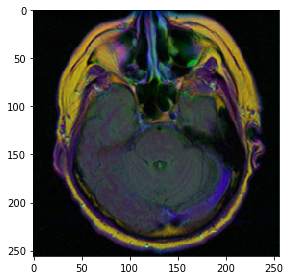

In [19]:
print('Images', img[11])
imshow(img[11])

Mask [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


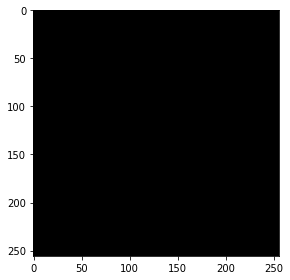

In [20]:
print('Mask', mas[11])
imshow(mas[11])

**Covert to np array**

In [21]:
images = np.array(img,dtype='uint8')
masks = np.array(mas,dtype='uint8')

print("Shape of Images ", images.shape)
print("Shape of Masks ", masks.shape)

Shape of Images  (14, 256, 256, 3)
Shape of Masks  (14, 256, 256, 3)


In [22]:
print(images)

[[[[0 4 1]
   [0 2 2]
   [0 2 3]
   ...
   [0 4 2]
   [0 3 2]
   [0 2 2]]

  [[0 4 1]
   [0 2 2]
   [0 2 2]
   ...
   [0 5 2]
   [0 7 2]
   [0 6 2]]

  [[0 3 2]
   [0 4 3]
   [0 3 2]
   ...
   [0 4 1]
   [0 5 1]
   [0 4 2]]

  ...

  [[0 8 2]
   [0 4 1]
   [0 2 2]
   ...
   [0 7 1]
   [0 6 1]
   [0 2 1]]

  [[0 4 3]
   [0 0 3]
   [0 0 2]
   ...
   [0 7 2]
   [0 8 1]
   [0 2 1]]

  [[0 2 2]
   [0 0 3]
   [0 2 2]
   ...
   [0 8 2]
   [0 9 2]
   [0 2 2]]]


 [[[0 0 4]
   [0 0 4]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 2]
   [0 0 1]
   [0 0 1]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 2]
   [0 0 3]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 3 2]
   [0 4 2]
   [1 4 1]
   ...
   [1 6 1]
   [0 5 1]
   [0 2 1]]

  [[0 4 1]
   [0 4 2]
   [0 4 2]
   ...
   [1 5 2]
   [0 6 1]
   [0 4 1]]

  [[0 3 1]
   [0 2 1]
   [0 2 1]
   ...
   [0 2 1]
   [0 1 2]
   [0 2 3]]]


 [[[0 2 1]
   [0 3 0]
   [0 3 2]
   ...
   [0 2 2]
   [0 2 1]
   [0 2 1]]

  [[0 6

Images_11 [[[0 3 1]
  [0 3 1]
  [0 4 0]
  ...
  [0 3 2]
  [0 3 2]
  [0 3 1]]

 [[0 4 0]
  [0 4 2]
  [0 4 1]
  ...
  [0 6 2]
  [0 6 1]
  [0 4 1]]

 [[0 3 2]
  [0 4 2]
  [0 4 2]
  ...
  [0 8 3]
  [0 9 2]
  [0 5 2]]

 ...

 [[0 6 2]
  [0 7 2]
  [0 3 1]
  ...
  [0 2 2]
  [0 2 3]
  [0 4 1]]

 [[0 7 1]
  [0 8 1]
  [0 4 1]
  ...
  [0 3 3]
  [0 2 4]
  [0 3 2]]

 [[0 5 1]
  [0 1 1]
  [0 4 1]
  ...
  [0 6 3]
  [0 2 1]
  [0 1 1]]]


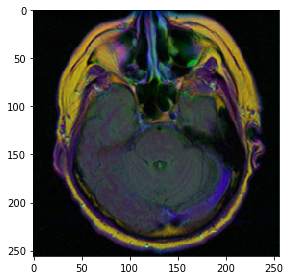

In [23]:
imshow(images[11])
print('Images_11', images[11])

Masks_11 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


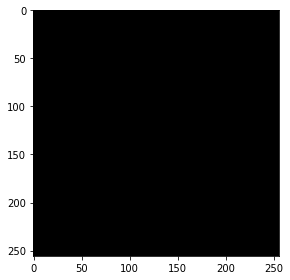

In [24]:
print("Masks_11", masks[11])
imshow(masks[11])

**Display random iteration of images from the dataset with their masks**


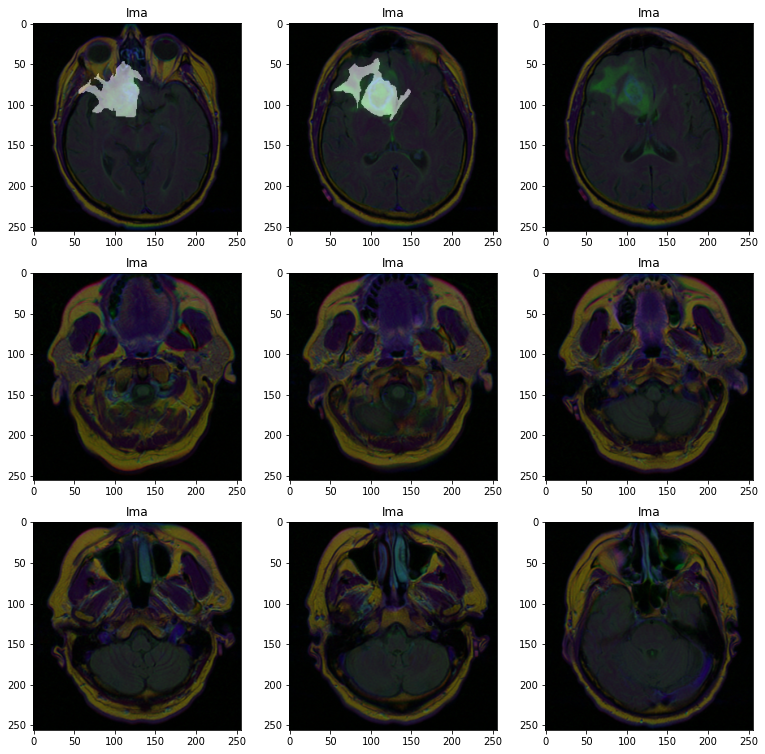

In [25]:

fig = plt.figure(figsize=(13, 13))
rnd_no = np.random.randint(0,len(images)-9)
for ind, i in enumerate(range(rnd_no, rnd_no+9)):
    
    fig.add_subplot(3,3,ind+1)
    
    # get image & mask file paths
    img_path = images[i]
    msk_path = masks[i]
   
    # read images
    #img = imshow(img_path)
    #msk = imshow(msk_path)
    
    # display images
  
    plt.imshow(img_path)
    plt.imshow(msk_path, alpha=0.5)
    plt.title('Ima'.split('/')[-1].split('.')[0])

plt.show()

**Spliting**

In [26]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size = .3,random_state = 42)

In [27]:
print("Shape of Train Images ", images_train.shape)
print("Shape of Test Images ", images_test.shape)
print("Shape of Train Masks ", masks_train.shape)
print("Shape of Test Masks ", masks_test.shape)

Shape of Train Images  (9, 256, 256, 3)
Shape of Test Images  (5, 256, 256, 3)
Shape of Train Masks  (9, 256, 256, 3)
Shape of Test Masks  (5, 256, 256, 3)


**Changing the channel number**

In [28]:
images_train = np.array(images_train).reshape(-1, IMG_HEIGHT,IMG_WIDTH,1)
print(images_train.shape)
images_test = np.array(images_test).reshape(-1, IMG_HEIGHT,IMG_WIDTH,1)
print(images_test.shape)
masks_train = np.array(masks_train).reshape(-1, IMG_HEIGHT,IMG_WIDTH,1)
print(masks_train.shape)
masks_test = np.array(masks_test).reshape(-1, IMG_HEIGHT,IMG_WIDTH,1)
print(masks_test.shape)

(108, 128, 128, 1)
(60, 128, 128, 1)
(108, 128, 128, 1)
(60, 128, 128, 1)


In [ ]:
#plt.imshow(images_train[1])
print(images_train[1])

[[[119]
  [ 64]
  [172]
  ...
  [ 65]
  [ 49]
  [ 91]]

 [[ 70]
  [ 45]
  [ 87]
  ...
  [ 84]
  [ 64]
  [ 63]]

 [[ 81]
  [ 68]
  [ 69]
  ...
  [ 11]
  [ 18]
  [  4]]

 ...

 [[ 48]
  [177]
  [155]
  ...
  [119]
  [176]
  [122]]

 [[ 88]
  [170]
  [ 96]
  ...
  [ 55]
  [ 31]
  [114]]

 [[ 52]
  [ 25]
  [113]
  ...
  [ 92]
  [ 81]
  [ 95]]]


**Build the U net model**

In [29]:

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [31]:
print('Output Shape ',outputs.shape)

Output Shape  (None, 128, 128, 1)


In [32]:
print("Input Shape: ", inputs.shape)

Input Shape:  (None, 128, 128, 1)


**Way 1**

**Creating augmentation object**

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen  = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range = 0.05,
                                    height_shift_range = 0.05,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    rotation_range = 30,
                                    fill_mode = 'nearest',
                                    zoom_range = 0.2,
                                    shear_range = 0.2)

# Fitting to train data 
    #train_datagen.fit(images_train)


In [34]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(train_datagen.flow(images_train, masks_train, batch_size = 5), validation_data =(images_test, masks_test), epochs = 5, verbose = 1)

Epoch 1/5
22/22 [==============================] - 18s 203ms/step - loss: 352.1111 - accuracy: 0.0214 - val_loss: 75574360.0000 - val_accuracy: 0.3271
Epoch 2/5
22/22 [==============================] - 1s 61ms/step - loss: -15512699404288.0000 - accuracy: 0.2355 - val_loss: 198363601436672.0000 - val_accuracy: 0.0092
Epoch 3/5
22/22 [==============================] - 1s 56ms/step - loss: nan - accuracy: 0.2223 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/5
22/22 [==============================] - 1s 53ms/step - loss: nan - accuracy: 0.9835 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/5
22/22 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.9835 - val_loss: nan - val_accuracy: 1.0000


In [35]:
print(results.history.keys())
results.history['accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


[0.021439163014292717,
 0.23549172282218933,
 0.2223002165555954,
 0.9835307002067566,
 0.9835307002067566]

**Way 2**

**Modelcheckpoint**

In [37]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(images_train, masks_train, validation_split=0.2, batch_size=4, epochs=5)

Epoch 1/5
22/22 [==============================] - 5s 96ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9770
Epoch 2/5
22/22 [==============================] - 1s 45ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9770
Epoch 3/5
22/22 [==============================] - 1s 45ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9770
Epoch 4/5
22/22 [==============================] - 1s 45ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9770
Epoch 5/5
22/22 [==============================] - 1s 46ms/step - loss: nan - accuracy: 0.9852 - val_loss: nan - val_accuracy: 0.9770


In [42]:
masks_pred=model.predict(images_test)

preds_0 = masks_pred[10] * 255.0

x_test_0 = images_test[10] * 255.0


In [44]:
#predicting the test set result
masks_pred=model.predict(images_test)
masks_pred=(masks_pred >0.5)

print(type(masks_pred))

<class 'numpy.ndarray'>


In [45]:
masks_pred

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [46]:
masks_pred[1]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [49]:
print(results.history.keys())
results.history['accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


[0.9852046370506287,
 0.9852046370506287,
 0.9852046370506287,
 0.9852046370506287,
 0.9852046370506287]